## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.


### Содержание
### [1. Подготовка](#section_id1)
### [2. Анализ](#section_id2)
### [3. Обучение](#section_id3)
### [4. Тестирование](#section_id4)

<a id='section_id1'></a>

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col = 'datetime', parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.sort_index(inplace=True)

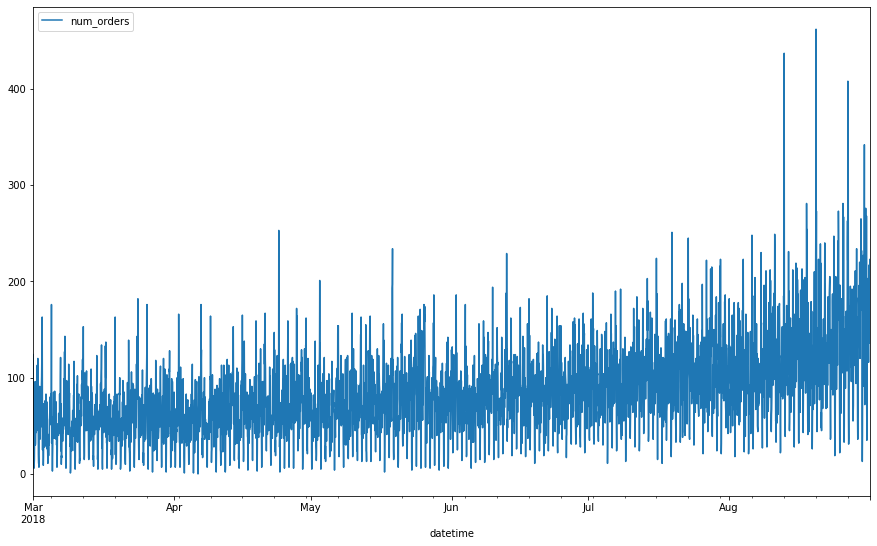

In [5]:
df = df.resample('1H').sum()
df.plot(figsize=(15,9))

<a id='section_id2'></a>

# 2. Анализ

На данном этапе были загружены данные, даты переведены в индекс с типом datetime. Также было проведено ресемплирование по 1 часу и построен график. По графику видно, что в июле в среднем кол-во заказов выше (мб это связано с большим кол-вом туристов в данное время). Попробуем посмотреть среднее значение, задав размер окна. Для анализа зададим просто по 1 дню, чтобы график был читабельным

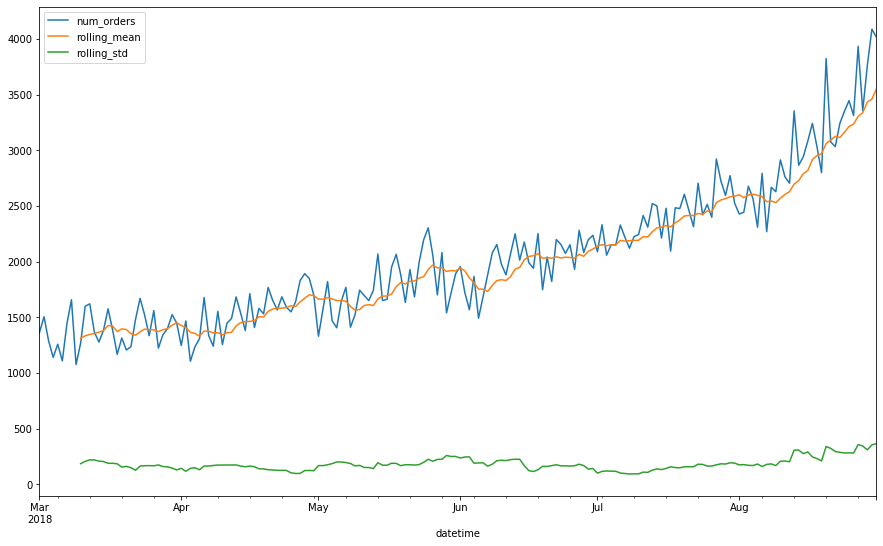

In [6]:
#создадим копию, чтобы не "портить" исходный датасет
df_roll = df.copy()
df_roll = df_roll.resample('1D').sum()
df_roll['rolling_mean'] = df_roll.rolling(10).mean()
df_roll['rolling_std'] = df_roll['num_orders'].rolling(10).std()
df_roll.plot(figsize=(15,9))

Как видим, среднее меняется в сторону увеличения, а вот стандартное отклонение идет на одном уровне.

In [7]:
df_roll = df_roll.drop(['rolling_mean', 'rolling_std'], axis= 1)

In [8]:
#также построим графики тренда и сезонности
decomposed = seasonal_decompose(df_roll)

Text(0.5, 1.0, 'Trend')

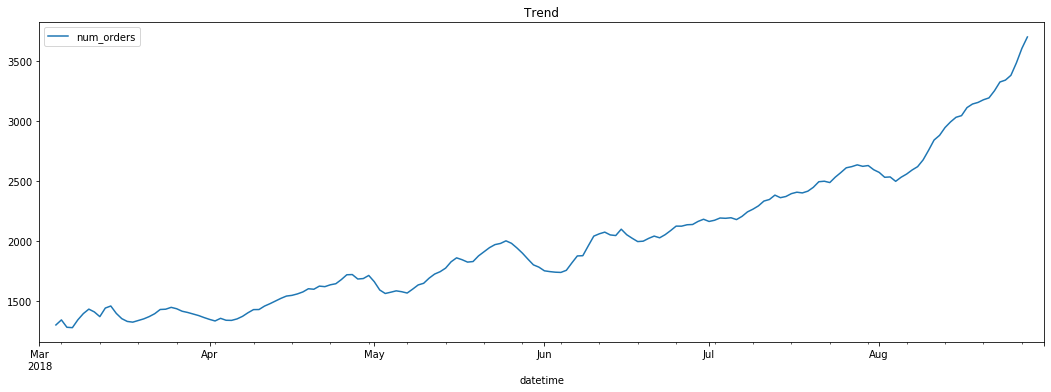

In [9]:
plt.figure(figsize=(18, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Text(0.5, 1.0, 'Seasonality')

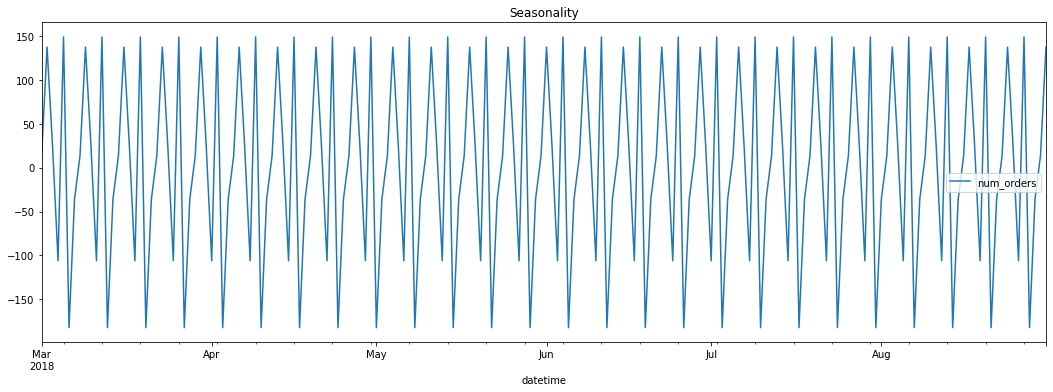

In [10]:
plt.figure(figsize=(18, 20))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Seasonality')

Text(0.5, 1.0, 'Residuals')

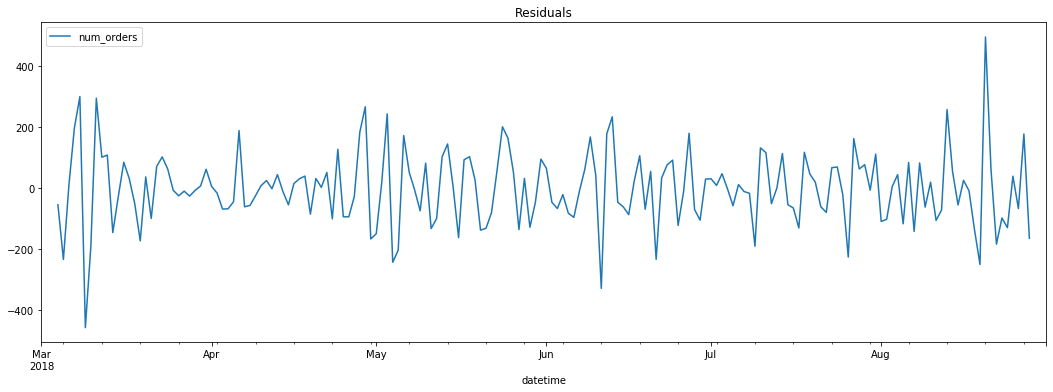

In [11]:
plt.figure(figsize=(18, 20))

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Residuals')

Как видим на графики "тренд", что идет плавное увеличение в потребности такси (начиная с июня идет хорошее увеличение, дабы все в отпусках и летают в дргуие страны). По сезону видно что цикл повторяется 4 раза в месяц.

<a id='section_id3'></a>

# 3. Обучение

In [12]:
#функция, которая определяет скользящее среднее и отстаюущие значения
def make_features(df_source, max_lag, rolling_mean_size):
    df = df_source.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [13]:
df_train = make_features(df, 25,10)

In [14]:
#по условию тестовая выборка должна составлять 10% от исходного датасета
train, valid = train_test_split(df_train, shuffle = False, test_size = 0.2)
valid, test = train_test_split(valid, shuffle = False, test_size = 0.5)

In [15]:
train = train.dropna()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3507 entries, 2018-03-02 01:00:00 to 2018-07-26 03:00:00
Freq: H
Data columns (total 32 columns):
num_orders      3507 non-null int64
year            3507 non-null int64
month           3507 non-null int64
day             3507 non-null int64
dayofweek       3507 non-null int64
hour            3507 non-null int64
lag_1           3507 non-null float64
lag_2           3507 non-null float64
lag_3           3507 non-null float64
lag_4           3507 non-null float64
lag_5           3507 non-null float64
lag_6           3507 non-null float64
lag_7           3507 non-null float64
lag_8           3507 non-null float64
lag_9           3507 non-null float64
lag_10          3507 non-null float64
lag_11          3507 non-null float64
lag_12          3507 non-null float64
lag_13          3507 non-null float64
lag_14          3507 non-null float64
lag_15          3507 non-null float64
lag_16          3507 non-null float64
lag_17          3507 non-

In [17]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-07-26 04:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 32 columns):
num_orders      442 non-null int64
year            442 non-null int64
month           442 non-null int64
day             442 non-null int64
dayofweek       442 non-null int64
hour            442 non-null int64
lag_1           442 non-null float64
lag_2           442 non-null float64
lag_3           442 non-null float64
lag_4           442 non-null float64
lag_5           442 non-null float64
lag_6           442 non-null float64
lag_7           442 non-null float64
lag_8           442 non-null float64
lag_9           442 non-null float64
lag_10          442 non-null float64
lag_11          442 non-null float64
lag_12          442 non-null float64
lag_13          442 non-null float64
lag_14          442 non-null float64
lag_15          442 non-null float64
lag_16          442 non-null float64
lag_17          442 non-null float64
lag_18     

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 32 columns):
num_orders      442 non-null int64
year            442 non-null int64
month           442 non-null int64
day             442 non-null int64
dayofweek       442 non-null int64
hour            442 non-null int64
lag_1           442 non-null float64
lag_2           442 non-null float64
lag_3           442 non-null float64
lag_4           442 non-null float64
lag_5           442 non-null float64
lag_6           442 non-null float64
lag_7           442 non-null float64
lag_8           442 non-null float64
lag_9           442 non-null float64
lag_10          442 non-null float64
lag_11          442 non-null float64
lag_12          442 non-null float64
lag_13          442 non-null float64
lag_14          442 non-null float64
lag_15          442 non-null float64
lag_16          442 non-null float64
lag_17          442 non-null float64
lag_18     

In [19]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = test.drop('num_orders', axis=1)
target_valid = test['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [20]:
print('train')
print(features_train.shape)
print(target_train.shape)
print('\nvalid')
print(features_valid.shape)
print(target_valid.shape)
print('\ntest')
print(features_test.shape)
print(target_test.shape)

train
(3507, 31)
(3507,)

valid
(442, 31)
(442,)

test
(442, 31)
(442,)


In [21]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)
predict_valid_linear = model_linear.predict(features_valid)

In [22]:
print("RMSE валидационной выборки линейная регрессия:", mean_squared_error(target_valid, predict_valid_linear)**0.5)

RMSE валидационной выборки линейная регрессия: 46.6097129756207


In [23]:
model_random_forest = RandomForestRegressor(random_state=12345)
param_search = {'n_estimators': range(1,20),
               'max_depth': range(1,14)}

In [24]:
grid = GridSearchCV(estimator = model_random_forest, param_grid = param_search)
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 7, 'n_estimators': 19}

In [25]:
model_random_forest = RandomForestRegressor(n_estimators = 19, max_depth = 7, random_state = 12345)

In [26]:
model_random_forest.fit(features_train, target_train)
predict_valid_random_forest = model_random_forest.predict(features_valid)

In [27]:
print("RMSE валидационной выборки случайный лес:", mean_squared_error(target_valid, predict_valid_random_forest)**0.5)

RMSE валидационной выборки случайный лес: 52.96958635079408


<a id='section_id4'></a>

# 4. Тестирование

In [28]:
predictions_test_linear = model_linear.predict(features_test)

In [29]:
print("RMSE тестовой выборки Линейной регрессии:", mean_squared_error(target_test, predictions_test_linear)**0.5)

RMSE тестовой выборки Линейной регрессии: 46.6097129756207


In [30]:
predictions_test_random_forest = model_random_forest.predict(features_test)

In [31]:
print("RMSE тестовой выборки Случайного леса:", mean_squared_error(target_test, predictions_test_random_forest)**0.5)

RMSE тестовой выборки Случайного леса: 52.96958635079408


В данном проекте необходимо было спрогнозировать количество заказов такси на следующий час. Для этого провели ресемлирование датасета по 1 часу, провели анализ, посмотрели как ведут себя стандартное отклонение и среднее значение (стандартное отклонение практически одинаково, а вот среднее ближе к августу становится все больше, сложно определить с чем это связано, было бы круто иметь датасет на несколько лет и посмотреть сезонность это или нет). Перед обучением были созданы признаки: календарные признаки (т.к. во многих данных тренды и сезонность привязаны к конкретной дате) и отстающие значения, которые подсказывали, будет ли функция x(t) расти или уменьшаться, и скользящее среднее, задающий тренд временного ряда. По условию надо было получить стандартное отклонение ниже 48. Данного показателя удалось достичь только при линейной регрессии (46,6), используя 25 признаков отстающих значений и скользящее среднее равной 10 (у случайного леса получилось 52).